# KNN Classifier 
---

In [10]:
# Imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize
import seaborn as sns

In [ ]:
# Get Processed Data
data = pd.read_csv('../data/processed/NY_SLI_YEARS_EXTRACTED.csv')

# Quick Preprocess: Drop rows with Unknown SL Category Cleaned
data = data[data['SL Category Cleaned'] != 'Unknown']

C:\Users\natha\AppData\Local\Temp\ipykernel_4388\384649134.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/processed/NY_SLI_YEARS_EXTRACTED.csv')


   Longitude  Latitude
0  -73.91547  41.69294
1  -73.92114  41.69080
2  -73.97087  40.75169
3  -74.01557  40.65040
4  -73.90951  40.68235
Data shape before location fix: 312918


### Position Only Model - Latitude and Longitude

Classes: ['Lead' 'Non-Lead' 'Unknown']
Class distribution:
SL Category Cleaned
Non-Lead    225274
Unknown      86121
Lead          1523
Name: count, dtype: int64

Testing different K values...
K=1, ROC AUC: 0.7661
K=11, ROC AUC: 0.9109
K=21, ROC AUC: 0.9255
K=31, ROC AUC: 0.9324
K=41, ROC AUC: 0.9334

Optimal K: 38
Best ROC AUC Score: 0.9340



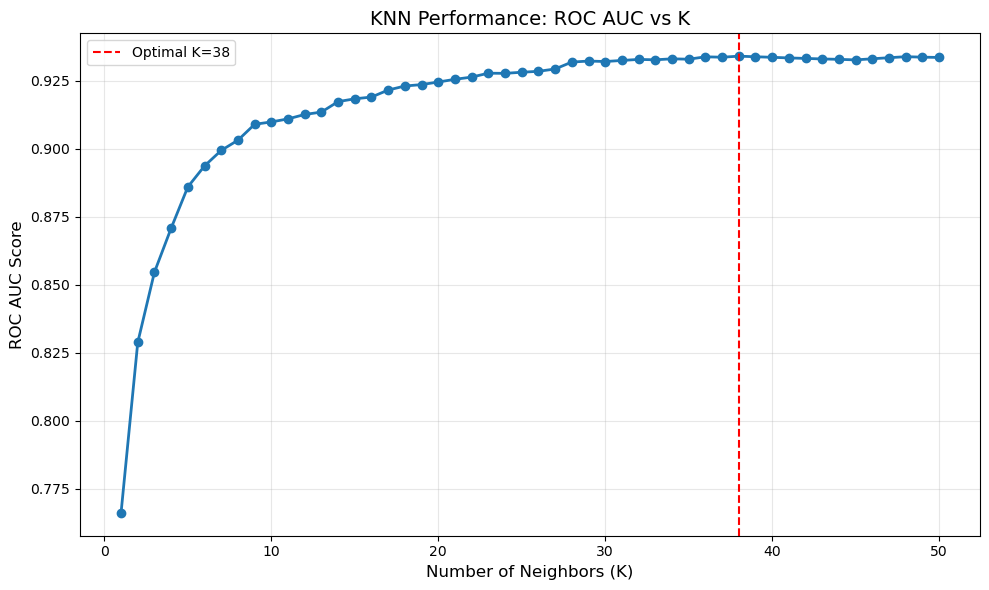

Classification Report:
              precision    recall  f1-score   support

        Lead       0.42      0.05      0.08       305
    Non-Lead       0.91      0.93      0.92     45055
     Unknown       0.80      0.76      0.78     17224

    accuracy                           0.88     62584
   macro avg       0.71      0.58      0.59     62584
weighted avg       0.87      0.88      0.87     62584



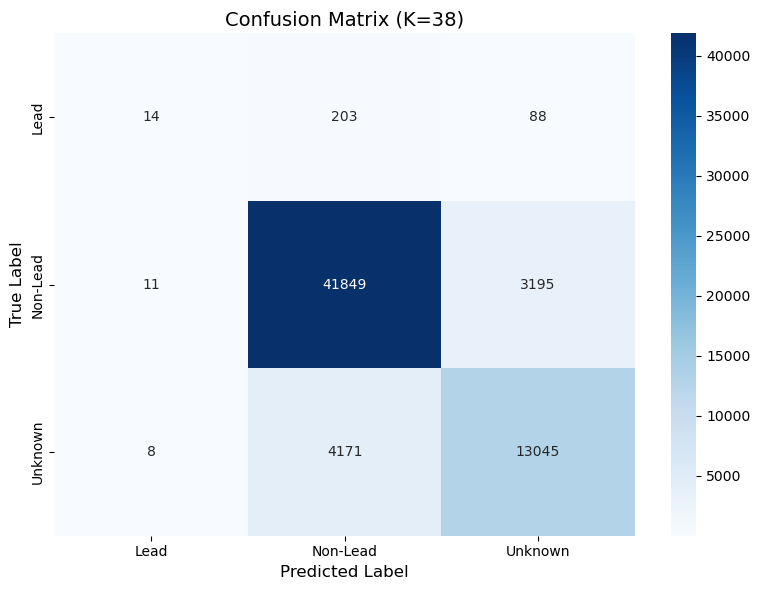

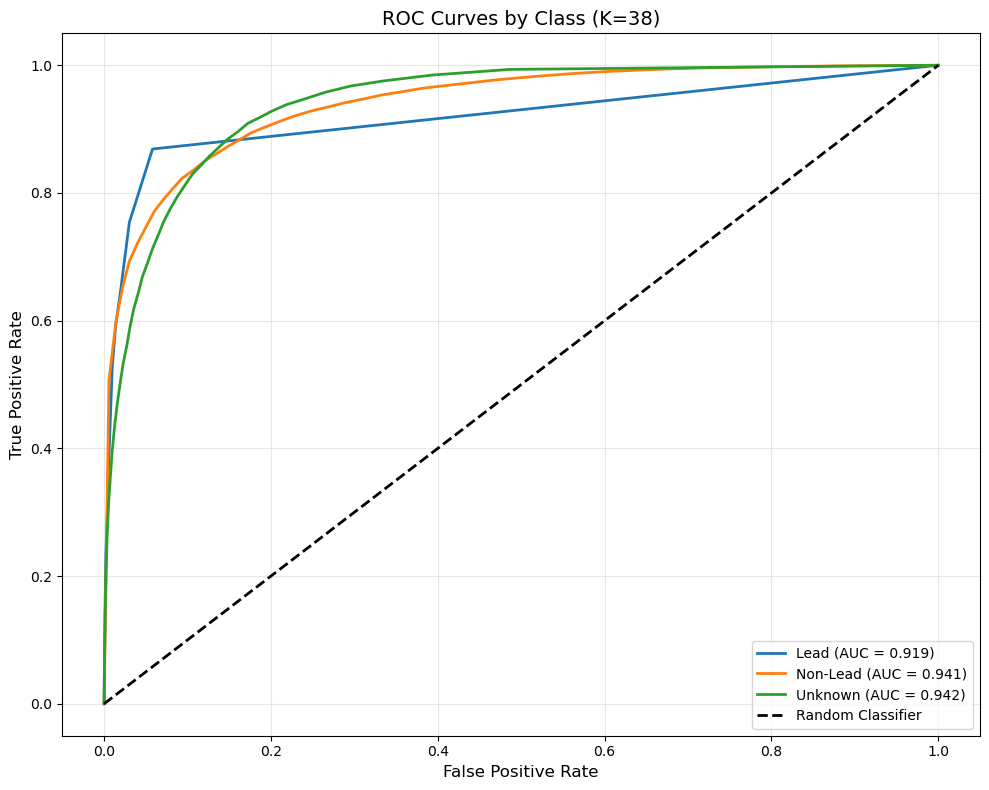


Model trained successfully with K=38


In [11]:
# Prepare features and target
X = data[['Latitude', 'Longitude']].copy()
y = data['SL Category Cleaned'].copy()

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
n_classes = len(le.classes_)

print(f"Classes: {le.classes_}")
print(f"Class distribution:\n{y.value_counts()}\n")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Test different K values
k_range = range(1, 51)
roc_auc_scores = []

print("Testing different K values...")
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    
    # Get probability predictions
    y_pred_proba = knn.predict_proba(X_test_scaled)
    
    # Calculate ROC AUC (using macro average for multi-class)
    if n_classes == 2:
        roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
    else:
        # For multi-class, use one-vs-rest approach
        roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
    
    roc_auc_scores.append(roc_auc)
    
    if k % 10 == 1:
        print(f"K={k}, ROC AUC: {roc_auc:.4f}")

# Find optimal K
optimal_k = k_range[np.argmax(roc_auc_scores)]
optimal_auc = max(roc_auc_scores)

print(f"\nOptimal K: {optimal_k}")
print(f"Best ROC AUC Score: {optimal_auc:.4f}\n")

# Plot ROC AUC vs K
plt.figure(figsize=(10, 6))
plt.plot(k_range, roc_auc_scores, marker='o', linestyle='-', linewidth=2)
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal K={optimal_k}')
plt.xlabel('Number of Neighbors (K)', fontsize=12)
plt.ylabel('ROC AUC Score', fontsize=12)
plt.title('KNN Performance: ROC AUC vs K', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Train final model with optimal K
final_knn = KNeighborsClassifier(n_neighbors=optimal_k)
final_knn.fit(X_train_scaled, y_train)

# Make predictions
y_pred = final_knn.predict(X_test_scaled)
y_pred_proba = final_knn.predict_proba(X_test_scaled)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Confusion Matrix (K={optimal_k})', fontsize=14)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Plot ROC curves for each class
if n_classes > 2:
    y_test_bin = label_binarize(y_test, classes=range(n_classes))
    
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, linewidth=2, 
                label=f'{le.classes_[i]} (AUC = {roc_auc:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves by Class (K={optimal_k})', fontsize=14)
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    # Binary classification
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, linewidth=2, label=f'KNN (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curve (K={optimal_k})', fontsize=14)
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Store the results
results = {
    'optimal_k': optimal_k,
    'optimal_auc': optimal_auc,
    'model': final_knn,
    'scaler': scaler,
    'label_encoder': le
}

print(f"\nModel trained successfully with K={optimal_k}")

### Running Additional Categories
